# Language processing: models & brains

> Marianne de Heer Kloots, 8/3/2022

In this notebook we explore how word meanings can be represented in neural network activations, specifically those of modern transformer models. We explore differences in these representations across layers, and between different models. Finally, we apply a very simple version of [representational similarity analysis](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full) to compare the models' activations when processing a Harry Potter chapter to brain scans of a human subject reading the same chapter. For this, we use one participant's data from the [openly available dataset by Wehbe et al. (2014)](http://www.cs.cmu.edu/~fmri/plosone/).  The transformer models used throughout this notebook are pretrained implementations of BERT and GPT2, publicly available through the [huggingface transformers](https://huggingface.co/) library.

In [1]:
from src.embeddings import *
from src.distance import *
from src.io import *

/home/mdhk/anaconda3/envs/nlrse-brainnlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import transformers
import pandas as pd
import scprep
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import os
import wget
import copy
import nilearn.signal

In [3]:
# check torch computing device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Word embeddings from transformer models

In [4]:
# load two different transformer models
bert_model, bert_tokenizer = model_init('bert-base-uncased')
gpt2_model, gpt2_tokenizer = model_init('gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


First, let's see how the model relates some collection of words in space.

In [5]:
# define a list of words to create embeddings for
words = [["boy"], 
         ["girl"], 
         ["man"], 
         ["woman"], 
         ["king"], 
         ["queen"], 
         ["prince"], 
         ["princess"]]

Below we retrieve the activations in each layer of the BERT model, for the 8 input words.

In [6]:
layer_activations = get_layer_activations(bert_model, 
                                          bert_tokenizer, 
                                          words)

We just visualize the input embeddings for now.

In [7]:
# retrieve the input embeddings (i.e. the layer activations at index 0),
# for each word
input_embeddings = pd.DataFrame(
    [a[0, 0, :] for a in layer_activations], 
    index=[w[0] for w in words]
)

# reduce to 3 dimensions (by PCA)
data_pca = scprep.reduce.pca(input_embeddings, 
                             n_components=3, 
                             method="dense")

In [8]:
# store 3d scatter plot
fig = px.scatter_3d(data_pca, x='PC1', y='PC2', z='PC3', 
                    color=data_pca.index)
if not os.path.isdir('../results'):
    os.mkdir('../results')
# open the html file to view the 3d plot
fig.write_html('../results/input_embeddings_viz.html')

## Contextualization across layers

Now we will look at the embeddings for the word 'mouse' in two different sentences:

1. "A computer needs a mouse."
2. "A cat eats a mouse."

These sentences illustrate two different meanings of the same word 'mouse'. We will see that the model's activations for the word mouse become more different from eachother in deeper layers.

In [9]:
sentences = [["A", "computer", "needs", "a", "mouse"],
             ["A", "cat", "eats", "a", "mouse"]]

In [10]:
layer_activations = get_layer_activations(bert_model, 
                                          bert_tokenizer, 
                                          sentences)

In this case we want the embeddings for all layers, but only for the last word (mouse).

In [11]:
# retrieve embeddings across layers for the word mouse (at index -1)
# for sentence 1 and sentence 2
mouse1, mouse2 = [a[-1,:,:] for a in layer_activations]
N_layers = len(mouse1)

Indeed, the distance between the mouse of sentence 1 and the mouse of sentence 2 increases with layer depth.

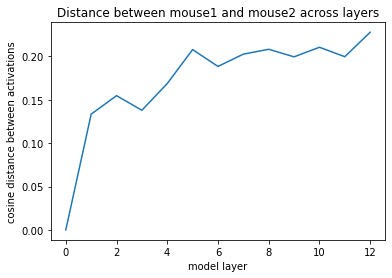

In [12]:
mouse_distances = [cosine(mouse1[layer,:], mouse2[layer,:])
             for layer in range(N_layers)]
plt.plot(mouse_distances)
plt.xlabel('model layer')
plt.ylabel('cosine distance between activations')
plt.title('Distance between mouse1 and mouse2 across layers')
plt.show()

Let's also look at the distances to the embeddings of 'computer' and 'cat', for the activations of both mouse1 and mouse2, across layers.

In [13]:
computer = layer_activations[0][1,0,:]
cat = layer_activations[1][1,0,:]

The distance between mouse2 and computer is larger than the distance between mouse1 and computer, pretty consistently across layers.

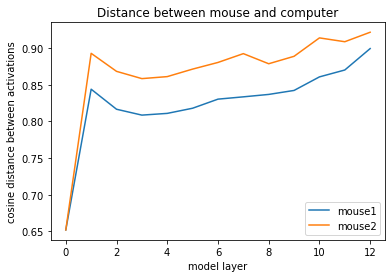

In [14]:
mouse1_computer = [cosine(mouse1[layer,:], computer)
             for layer in range(N_layers)]
mouse2_computer = [cosine(mouse2[layer,:], computer)
             for layer in range(N_layers)]
plt.plot(mouse1_computer, label='mouse1')
plt.plot(mouse2_computer, label='mouse2')
plt.xlabel('model layer')
plt.ylabel('cosine distance between activations')
plt.title('Distance between mouse and computer')
plt.legend(loc='lower right')
plt.show()

The distance to cat is larger for mouse1 than for mouse2, but this is primarily the case for earlier and middle layers of the model.

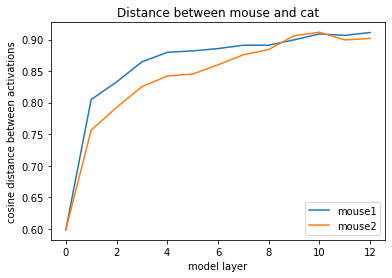

In [15]:
mouse1_cat = [cosine(mouse1[layer,:], cat)
             for layer in range(N_layers)]
mouse2_cat = [cosine(mouse2[layer,:], cat)
             for layer in range(N_layers)]
plt.plot(mouse1_cat, label='mouse1')
plt.plot(mouse2_cat, label='mouse2')
plt.xlabel('model layer')
plt.ylabel('cosine distance between activations')
plt.title('Distance between mouse and cat')
plt.legend(loc='lower right')
plt.show()

You can try to rerun the code for this section but using `gpt2_model` and `gpt2_tokenizer` as arguments when computing the layer activations, to see if this pattern holds for the other model.

## Comparing two models

Let's see how the internal representations of the two transformer models (BERT and GPT2) differ. To do this, we will compute distance matrices for every layer in each model, between the activations for every word.

In [16]:
text = [["A", "computer", "needs", "a", "mouse.", 
        "A", "cat", "eats", "a", "mouse."]]

In [17]:
layer_activations_bert = get_layer_activations(bert_model, 
                                          bert_tokenizer, 
                                          text)[0]

layer_activations_gpt2 = get_layer_activations(gpt2_model, 
                                          gpt2_tokenizer, 
                                          text)[0]

In [18]:
def plot_layer_distance_matrix(layer_activations, layer):
    plt.imshow(vector_distance_matrix(layer_activations[:,layer,:], 
                                metric='cosine'))
    plt.xticks(ticks=range(len(text[0])),labels=text[0],rotation=90)
    plt.yticks(ticks=range(len(text[0])),labels=text[0])
    plt.colorbar()
    plt.title(f'Distance matrix for layer {layer}')
    plt.show()

Below are the distance matrices for two different layers of BERT. Note that the matrices are symmetrical, and the diagonal is 0.

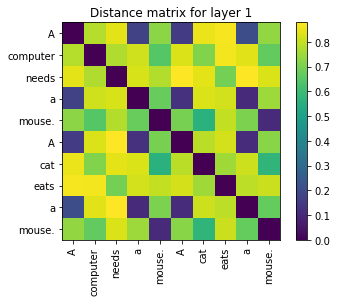

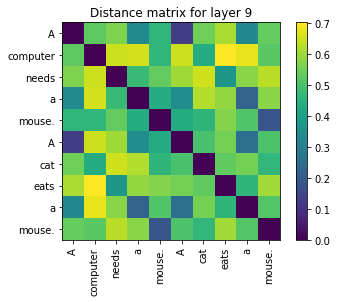

In [19]:
plot_layer_distance_matrix(layer_activations_bert, 1)
plot_layer_distance_matrix(layer_activations_bert, 9)

The distance matrices for two layers of GPT2, below, look quite different!

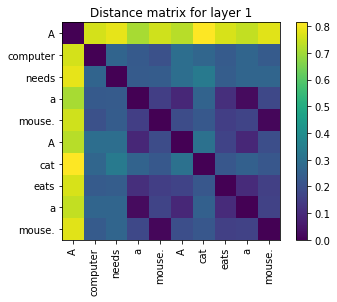

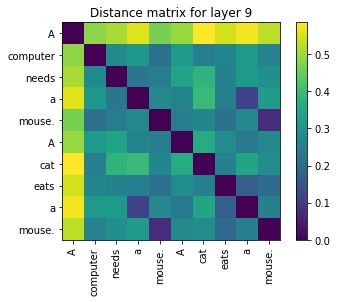

In [20]:
plot_layer_distance_matrix(layer_activations_gpt2, 1)
plot_layer_distance_matrix(layer_activations_gpt2, 9)

Note that we can in principle compute this kind of distance matrix for any distance measure between stimuli. For example the just the [(Levenshtein) edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between character strings: the minimum number of characters to change for getting from one string to the other.

In [21]:
def plot_edit_distance_matrix(text):
    plt.imshow(string_distance_matrix(text))
    plt.xticks(ticks=range(len(text)),labels=text,rotation=90)
    plt.yticks(ticks=range(len(text)),labels=text)
    plt.colorbar()
    plt.title(f'Edit distance matrix')
    plt.show()

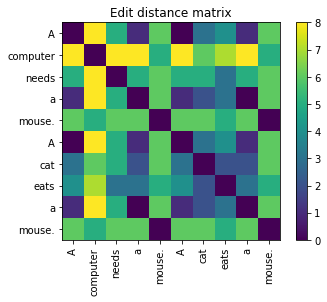

In [22]:
plot_edit_distance_matrix(text[0])

We can compute some kind of similarity score between distance matrices, to see how similarly the stimuli are represented in two different representational spaces (this is the idea behind [Representational Similarity Analysis](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full)).

Let's see how similar the distance patterns for the two models are to the edit distance pattern above, across different layers. We will call the distance matrices 'RDMs' now (_representational dissimilarity matrices_).

In [23]:
# we normalize the levenshtein distances in this case
levenshtein_RDM = string_distance_matrix(text[0], 
                                         normalize=True)

bert_RDMs = [vector_distance_matrix(
    layer_activations_bert[:,layer,:], metric='cosine')
    for layer in range(layer_activations_bert.shape[1])]

gpt2_RDMs = [vector_distance_matrix(
    layer_activations_gpt2[:,layer,:], metric='cosine')
    for layer in range(layer_activations_gpt2.shape[1])]

We need a similarity score to compare between pairs of matrices. We will use [pearson's r](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) for now.

In [24]:
bert_lev_rsa = [compute_rsa_score(levenshtein_RDM, 
                                  bert_RDMs[layer], 
                                  score='pearsonr')
                for layer in range(len(bert_RDMs))]

gpt2_lev_rsa = [compute_rsa_score(levenshtein_RDM,
                                  gpt2_RDMs[layer],
                                  score='pearsonr')
                for layer in range(len(gpt2_RDMs))]

The input embedding pattern (at index 0) for both models shows a relatively high correlation with the edit distance pattern. However, this similarity is only sustained across model layers for BERT, and not for GPT2. So this is a notable difference between the two models!

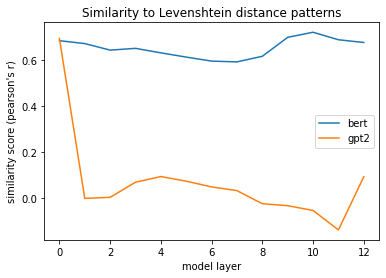

In [25]:
plt.plot(bert_lev_rsa, label='bert')
plt.plot(gpt2_lev_rsa, label='gpt2')
plt.ylabel('similarity score (pearson\'s r)')
plt.xlabel('model layer')
plt.title('Similarity to Levenshtein distance patterns')
plt.legend(loc='center right')
plt.show()

We can of course also compare RDMs between the two transformer models. It might make more sense in this case to compare all layers of either model to eachother, since there is no guarantee that for example layer 4 of BERT is comparable to layer 4 of GPT2 -- similar operations might occur at different locations in either model.

This gives us a 12 by 12 matrix of similarities between all layers of each model (we omit the input embeddings this time):

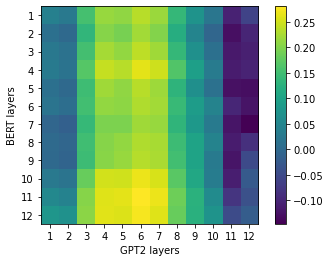

In [26]:
rsa_mat = rsa_matrix(bert_RDMs[1:], gpt2_RDMs[1:])
plt.imshow(rsa_mat)
plt.ylabel('BERT layers')
plt.yticks(ticks=range(0,12), labels=range(1,13))
plt.xlabel('GPT2 layers')
plt.xticks(ticks=range(0,12), labels=range(1,13))
plt.colorbar()
plt.show()

It seems the middle layers of GPT2 are most similar to all of BERT.

## Comparing models and brain

Download data for one subject from the [Harry Potter dataset by Wehbe et al. (2014)](http://www.cs.cmu.edu/~fmri/plosone/), into the results directory:

In [27]:
if not os.path.exists('../data/subject_1.mat'):
    url = 'http://www.cs.cmu.edu/~fmri/plosone/files/subject_1.mat'
    wget.download(url, out='../data/')

100% [..................................................] 52746178 / 52746178

In [28]:
subj_dict = load_subj_dict('../data/subject_1.mat')

We still need to do some preprocessing (detrending) on the fMRI data; we use the `signal.clean` function from the [nilearn](https://nilearn.github.io/stable/index.html) library for this.

In [29]:
if not os.path.exists('../results/subject_1_clean.npy'):
    # preprocessing parameters
    cleaning_params = {
        't_r': 2,                 # TR length in seconds
        'low_pass': None,         # low-pass filter frequency cutoff (Hz)
        'high_pass': 0.005,       # high-pass filter frequency cutoff (Hz)
        'standardize': 'zscore',  # standardization method
        'detrend': True,          # whether to apply detrending
    }

    cleaned_subj_dict = copy.copy(subj_dict)
    cleaned_subj_dict['data'] = nilearn.signal.clean(subj_dict['data'], 
                                    runs=subj_dict['time'][:,1], 
                                    **cleaning_params)
    if not os.path.isdir('../results'):
        os.mkdir('../results')
    np.save('../results/subject_1_clean.npy', cleaned_subj_dict)
subj_dict = np.load('../results/subject_1_clean.npy', allow_pickle=True).item()

Collect only the brain responses to text stimuli (and apply a 4 second delay to account for the hemodynamic response duration):

In [30]:
brain_responses = get_text_response_scans(subj_dict, 
                                          delay=2) # delay in TRs (1 TR = 2 sec)
brain_responses['voxel_signals'].shape

(1295, 37913)

Each brain scan lasted 2 seconds (the 'TR' time), and during every scan the experiment participants read 4 words. In total, 1295 scans were made while the subject was reading (the first number above). For this subject, we have information from 37913 voxels in every scan (the second number).

The file `tr_texts.txt` in the data directory contains the words presented during each TR, with one TR per line.
These texts have been slightly processed from the Wehbe dataset to remove some strange characters; therefore we provide it here separately.

Below we use these texts first to create sentences to feed to the models.

In [31]:
tr_texts = open('../data/tr_texts.txt', 'r').read().splitlines()
words_per_tr = [len(tr.split(' ')) for tr in tr_texts]
hp_sentences = create_context_sentences(tr_texts)

When we feed the sentences to the models, we receive the layer activations for every word. 

To get embeddings per TR, we average over the words in each TR (i.e. when 4 words were presented during one TR, we take the mean over the model's activations for those 4 words to create the TR embedding).

In [ ]:
layer_acts_bert = get_layer_activations(bert_model, 
                      bert_tokenizer, 
                      hp_sentences)
layer_acts_bert = np.concatenate(layer_acts_bert)
tr_embeddings_bert = get_tr_embeddings(layer_acts_bert, words_per_tr)

layer_acts_gpt2 = get_layer_activations(gpt2_model,
                      gpt2_tokenizer,
                      hp_sentences)
layer_acts_gpt2 = np.concatenate(layer_acts_gpt2)
tr_embeddings_gpt2 = get_tr_embeddings(layer_acts_gpt2, words_per_tr)

Now we have model embeddings for every TR (the first number below) and every layer (the second number). The third number is the dimensionality of the model embeddings (768 for both).

In [ ]:
print(tr_embeddings_bert.shape)
print(tr_embeddings_gpt2.shape)

We are ready to compute RDMs and representational similarity scores!

In [ ]:
RDMs_bert = [vector_distance_matrix(tr_embeddings_bert[:,layer,:],
                                   metric="cosine")
             for layer in range(tr_embeddings_bert.shape[1])]
RDMs_gpt2 = [vector_distance_matrix(tr_embeddings_gpt2[:,layer,:],
                                    metric="cosine")
             for layer in range(tr_embeddings_gpt2.shape[1])]

RDM_brain = vector_distance_matrix(brain_responses['voxel_signals'],
                                   metric="cosine")

In [ ]:
rsa_scores_bert = [compute_rsa_score(RDM_brain,
                                     RDMs_bert[layer])
                   for layer in range(len(RDMs_bert))]
rsa_scores_gpt2 = [compute_rsa_score(RDM_brain,
                                     RDMs_gpt2[layer])
                   for layer in range(len(RDMs_gpt2))]

It turns out that the absolute model-brain similarities are not very high in this case, but we can still observe some interesting things. For example, BERT has higher similarity overall than GPT2, and similarity increases with layer depth. 

In [ ]:
plt.plot(rsa_scores_bert, label='bert')
plt.plot(rsa_scores_gpt2, label='gpt2')
plt.xlabel('model layer')
plt.ylabel('similarity score (pearson\'s r)')
plt.title('Model-brain similarities for subject 1')
plt.legend()
plt.show()

This pattern is consistent across subjects. We can also improve the model embeddings by giving the model a bit more context (for example a few sentences, rather than just one); this in turn improves the similarity scores.

## Further resources

Here we outlined one way of exploring similarities between human language processing data and neural network activations from large language models. 

In this case, we used [fMRI](https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging), which gives us relatively detailed spatial information, so we can for example compare different brain regions next (the dataset is annotated with 117 regions of interest). But we could use the same tools for analyzing different data, such as [EEG](https://en.wikipedia.org/wiki/Electroencephalography) (which has better temporal resolution) or [eye tracking](https://en.wikipedia.org/wiki/Eye_tracking). 
[This wiki](https://github.com/norahollenstein/cognitiveNLP-dataCollection/wiki/) lists openly available data sources on cognitive processing during language understanding, if you are interested to explore this further. 

If you are interested in seeing another approach applied to modelling eye tracking data, check out [this tutorial notebook](https://colab.research.google.com/drive/1c1oI8awEj5tz5yRoGS1jmjr5zABNXIs3?usp=sharing) (used as a lab assignment in a master's course).